# A Phosphorus Cycling Model

## Tracer equations

We consider a simple model for the cycling of phosphorus with 3 state variables consisting of phosphate (PO₄) AKA dissolved inorganic phosphorus (DIP), dissolved organic phosphorus (DOP), and particulate organic phosphorus (POP).

The dissolved phases are transported by advection and diffusion whereas the particulate phase sinks rapidly down the water column without any appreciable transport by the circulation.

The governing equations are:

$$\frac{\partial}{\partial t} DIP + \nabla \cdot \left[\boldsymbol{u} + \mathbf{K}\cdot\nabla \right] DIP = -\gamma(DIP) + \kappa_\mathsf{D} \, DOP,$$

$$\frac{\partial}{\partial t} DOP + \nabla \cdot \left[\boldsymbol{u} + \mathbf{K}\cdot \nabla \right] DOP = \sigma \, \gamma(DIP) + \kappa_\mathsf{P} \, POP - \kappa_\mathsf{D} \, DOP,$$

and

$$\frac{\partial}{\partial t} POP + \frac{\partial}{\partial z} \left[w_\mathsf{P} \, POP\right] = (1-\sigma) \, \gamma(DIP) - \kappa_\mathsf{P} \, POP,$$

where $\boldsymbol{u}$ is the fluid velocity and $\mathbf{K}$ is the eddy-diffusion tensor.
Thus, $\nabla \cdot \left[ \boldsymbol{u} - \mathbf{K} \cdot \nabla \right]$ is a differential operator that represents the transport by the ocean circulation.
The function $\gamma(DIP)$ represents the biological uptake of DIP by phytoplankton.

Oxygen participates to this cycle too and satisfies its own tracer equation

$$\frac{\partial}{\partial t} DO_2 + \nabla \cdot \left[\boldsymbol{u} + \mathbf{K}\cdot\nabla \right] DO_2 = -r_{\mathsf{O}_2:\mathsf{P}} \, \kappa_\mathsf{D} \, DOP + \Lambda(DO_2 - [O_2]_{\mathsf{sat}})$$

where $\Lambda$ is the air-sea gas exchange operator.

These tracer equations depend on a number of scalars, that we list below

| Symbol                        | Definition                                                                  |
|:------------------------------|:----------------------------------------------------------------------------|
| $w_\mathsf{P}$                | depth dependent particle sinking speed                                      |
| $\sigma$                      | fraction of the organic matter production allocated to the dissolved phase  |
| $\kappa_\mathsf{D}$           | respiration rate for dissolved organic matter (DOP → DIP)                   |
| $\kappa_\mathsf{P}$           | dissolution rate for particulate organic matter (POP → DOP)                 |
| $r_{\mathsf{O}_2:\mathsf{P}}$ | number of moles of O₂ needed to respire 1 mole of DOP                       |

In [1]:
using AIBECS

Load the circulation and grid

In [2]:
wet3D, grd, T_Circulation = OCIM0.load() ;

Loading OCIM0.1┌ Warning: Over-writing registration of the datadep
│   name = AIBECS_OCIM0.1
└ @ DataDeps /home/travis/.julia/packages/DataDeps/RYAia/src/registration.jl:8
 ✔
┌ Info: You are about to use OCIM0.1 model.
│ If you use it for research, please cite:
│ 
│ - Primeau, F. W., Holzer, M., and DeVries, T. (2013), Southern Ocean nutrient trapping and the efficiency of the biological pump, J. Geophys. Res. Oceans, 118, 2547–2564, doi:10.1002/jgrc.20181.
│ - DeVries, T. and F. Primeau, 2011: Dynamically and Observationally Constrained Estimates of Water-Mass Distributions and Ages in the Global Ocean. J. Phys. Oceanogr., 41, 2381–2401, doi:10.1175/JPO-D-10-05011.1
│ 
│ You can find the corresponding BibTeX entries in the CITATION.bib file
│ at the root of the AIBECS.jl package repository.
│ (Look for the "DeVries_Primeau_2011" and "Primeau_etal_2013" keys.)
└ @ AIBECS.OCIM0 /home/travis/build/briochemc/AIBECS.jl/src/OCIM0.jl:53


Define useful constants and arrays

In [3]:
iwet = indices_of_wet_boxes(wet3D)
nb = length(iwet)
z = ustrip.(vector_of_depths(wet3D, grd))
ztop = vector_of_top_depths(wet3D, grd) ;

And matrices

In [4]:
DIV = buildDIV(wet3D, iwet, grd)
Iabove = buildIabove(wet3D, iwet) ;

### Transport matrices

In [5]:
T_DIP(p) = T_Circulation
T_DOP(p) = T_Circulation
T_DO2(p) = T_Circulation
S₀ = buildPFD(ones(nb), DIV, Iabove)
S′ = buildPFD(ztop, DIV, Iabove)
function T_POP(p)
    w₀, w′ = p.w₀, p.w′
    return w₀ * S₀ + w′ * S′
end
T_all = (T_DIP, T_DOP, T_POP, T_DO2) ;

Because AIBECS will solve for the steady state solution directly without time-stepping the goverining equations to equilibrium, we don't have any opportunity to specify any intial conditions.
Initial conditions are how the total amount of conserved elements get specified in most global biogeochemical modelels.
Thus to specify the total inventory of P in AIBECS we add a very weak resporing term to the DIP equation.
The time-scale for this restoring term is chosen to be very long compared to the timescale with which the ocean circulation homogenizes a tracer.
Because of this long timescale we call it the geological restoring term, but geochemists who work on geological processes don't like that name!
In any event the long timescale allows us to prescribe the total inventory of P in a way that yields the same solution we would have gotten had we time-stepped the model to steady-state with the total inventory prescribed by the initial condition.

### Sources minus sinks

##### Geological Restoring

In [6]:
function geores(x, p)
    τg, xgeo = p.τg, p.xgeo
    return (xgeo .- x) / τg
end

geores (generic function with 1 method)

##### Uptake of phosphate (DIP)

In [7]:
relu(x) = (x .≥ 0) .* x
function uptake(DIP, p)
    τu, ku, z₀ = p.τu, p.ku, p.z₀
    DIP⁺ = relu(DIP)
    return 1/τu * DIP⁺.^2 ./ (DIP⁺ .+ ku) .* (z .≤ z₀)
end

uptake (generic function with 1 method)

##### Remineralization DOP into DIP

In [8]:
function respiration(DOP, p)
    κDOP = p.κDOP
    return κDOP * DOP
end

respiration (generic function with 1 method)

##### Dissolution of POP into DOP

In [9]:
function dissolution(POP, p)
    κPOP = p.κPOP
    return κPOP * POP
end

dissolution (generic function with 1 method)

##### Air-sea gas exchange

In [10]:
h = ustrip(grd.δdepth[1])             # thickness of the top layer
z = grd.depth_3D[iwet]        # depth of the gridbox centers
using WorldOceanAtlasTools
WOA = WorldOceanAtlasTools
μDO2sat , σ²DO2sat = WOA.fit_to_grid(grd,2018,"O2sat","annual","1°","an") ;
DO2sat = vec(μDO2sat)[iwet]
function airsea(DO2, p)
    κDO2 = p.κDO2
    return κDO2 * (z .< 20u"m") .* (DO2sat .- DO2) / h
end

Registering WOA data with DataDeps
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  176M  100  176M    0     0  47.4M      0  0:00:03  0:00:03 --:--:-- 47.4M
┌ Warning: Checksum not provided, add to the Datadep Registration the following hash line
│   hash = 4052e380bb391eca7cd6e83b1bb282e8fae0ccb85e8cbd19041433bba481eba4
└ @ DataDeps /home/travis/.julia/packages/DataDeps/RYAia/src/verification.jl:44
  Reading NetCDF file
  Rearranging data
  Filtering data
  Averaging data over each grid box
  Setting μ = 0 and σ² = ∞ where no obs
  Setting a realistic minimum for σ²


airsea (generic function with 1 method)

Add them up into sms functions (Sources Minus Sinks)

In [11]:
function sms_DIP(DIP, DOP, POP, DO2, p)
    return -uptake(DIP, p) + respiration(DOP, p) + geores(DIP, p)
end
function sms_DOP(DIP, DOP, POP, DO2, p)
    σ = p.σ
    return σ * uptake(DIP, p) - respiration(DOP, p) + dissolution(POP, p)
end
function sms_POP(DIP, DOP, POP, DO2, p)
    σ = p.σ
    return (1 - σ) * uptake(DIP, p) - dissolution(POP, p)
end
function sms_DO2(DIP, DOP, POP, DO2, p)
    rO2P = p.rO2P
    return airsea(DO2,p) + rO2P * (uptake(DIP,p) - respiration(DOP,p))
end
sms_all = (sms_DIP, sms_DOP, sms_POP, sms_DO2,) # bundles all the source-sink functions in a tuple

(Main.##367.sms_DIP, Main.##367.sms_DOP, Main.##367.sms_POP, Main.##367.sms_DO2)

### Parameters

Build the parameters type and p₀

In [12]:
t = empty_parameter_table()    # initialize table of parameters
add_parameter!(t, :xgeo, 2.17u"mmol/m^3")
add_parameter!(t, :τg, 1.0u"Myr")
add_parameter!(t, :ku, 10.0u"μmol/m^3")
add_parameter!(t, :z₀, 80.0u"m")
add_parameter!(t, :w₀, 1.0u"m/d")
add_parameter!(t, :w′, 1/4.4625u"d")
add_parameter!(t, :κDOP, 1/0.25u"yr")
add_parameter!(t, :κPOP, 1/5.25u"d")
add_parameter!(t, :σ, 0.3u"1")
add_parameter!(t, :τu, 30.0u"d")
add_parameter!(t, :κDO2, 50u"m" / 30u"d")
add_parameter!(t, :rO2P, 175.0u"mol/mol")
initialize_Parameters_type(t, "DIP_DOP_POP_O₂_Parameters")   # Generate the parameter type

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = #add_parameter!#68(::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}, ::Function, ::DataFrames.DataFrame, ::Symbol, ::Vararg{Any,N} where N) at Parameters.jl:64
└ @ AIBECS /home/travis/build/briochemc/AIBECS.jl/src/Parameters.jl:64
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = initialize_Parameters_type(::DataFrames.DataFrame, ::String) at Parameters.jl:128
└ @ AIBECS /home/travis/build/briochemc/AIBECS.jl/src/Parameters.jl:128
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = initialize_Parameters_type(::DataFrames.DataFrame, ::String) at Parameters.jl:129
└ @ AIBECS /home/travis/build/briochemc/AIBECS.jl/src/Parameters.jl:129
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col

### Generate state function and Jacobian

In [13]:
nt = length(T_all)    # number of tracers
n = nt * nb           # total dimension of the state vector
p = DIP_DOP_POP_O₂_Parameters() # parameters
x = p.xgeo * ones(n) # initial iterate
F, ∇ₓF = state_function_and_Jacobian(T_all, sms_all, nb)

(getfield(AIBECS, Symbol("#F#24")){getfield(AIBECS, Symbol("#T#20")){Tuple{typeof(Main.##367.T_DIP),typeof(Main.##367.T_DOP),typeof(Main.##367.T_POP),typeof(Main.##367.T_DO2)}},getfield(AIBECS, Symbol("#G#22")){Tuple{typeof(Main.##367.sms_DIP),typeof(Main.##367.sms_DOP),typeof(Main.##367.sms_POP),typeof(Main.##367.sms_DO2)},getfield(AIBECS, Symbol("#tracers#19")){Int64,Int64}}}(getfield(AIBECS, Symbol("#T#20")){Tuple{typeof(Main.##367.T_DIP),typeof(Main.##367.T_DOP),typeof(Main.##367.T_POP),typeof(Main.##367.T_DO2)}}((Main.##367.T_DIP, Main.##367.T_DOP, Main.##367.T_POP, Main.##367.T_DO2)), getfield(AIBECS, Symbol("#G#22")){Tuple{typeof(Main.##367.sms_DIP),typeof(Main.##367.sms_DOP),typeof(Main.##367.sms_POP),typeof(Main.##367.sms_DO2)},getfield(AIBECS, Symbol("#tracers#19")){Int64,Int64}}((Main.##367.sms_DIP, Main.##367.sms_DOP, Main.##367.sms_POP, Main.##367.sms_DO2), getfield(AIBECS, Symbol("#tracers#19")){Int64,Int64}(191169, 4))), getfield(AIBECS, Symbol("#∇ₓF#26")){getfield(AIBEC

and solve

In [14]:
prob = SteadyStateProblem(F, ∇ₓF, x, p)
nothing # s = solve(prob, CTKAlg()) # Not working yet

unpack state

In [15]:
DIP, DOP, POP, DO2 = state_to_tracers(x, nb, nt) # remove when line below works
nothing # DIP, DOP, POP, DO2 = state_to_tracers(s.u, nb, nt)

We will plot the concentration of DIP at a given depth horizon

In [16]:
depth = grd.depth
iz = findfirst(depth .> 200u"m")
iz, depth[iz]

(6, 246.7350746268657 m)

In [17]:
DIP_3D = rearrange_into_3Darray(DIP, wet3D)
DIP_2D = DIP_3D[:,:,iz] * ustrip(1.0u"mol/m^3" |> u"mmol/m^3")
lat, lon = ustrip.(grd.lat), ustrip.(grd.lon)

([-89.0, -87.0, -85.0, -83.0, -81.0, -79.0, -77.0, -75.0, -73.0, -71.0  …  71.0, 73.0, 75.0, 77.0, 79.0, 81.0, 83.0, 85.0, 87.0, 89.0], [1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0, 17.0, 19.0  …  341.0, 343.0, 345.0, 347.0, 349.0, 351.0, 353.0, 355.0, 357.0, 359.0])

and plot

In [18]:
ENV["MPLBACKEND"]="qt5agg"
using PyPlot, PyCall
clf()
ccrs = pyimport("cartopy.crs")
ax = subplot(projection = ccrs.EqualEarth(central_longitude=-155.0))
ax.coastlines()

PyObject <cartopy.mpl.feature_artist.FeatureArtist object at 0x7f71023c0630>

making it cyclic for Cartopy

In [19]:
lon_cyc = [lon; 360+lon[1]]
DIP_2D_cyc = hcat(DIP_2D, DIP_2D[:,1])

90×181 Array{Float64,2}:
 NaN     NaN     NaN     NaN     NaN     …  NaN     NaN     NaN     NaN   
 NaN     NaN     NaN     NaN     NaN        NaN     NaN     NaN     NaN   
 NaN     NaN     NaN     NaN     NaN        NaN     NaN     NaN     NaN   
 NaN     NaN     NaN     NaN     NaN        NaN     NaN     NaN     NaN   
 NaN     NaN     NaN     NaN     NaN        NaN     NaN     NaN     NaN   
 NaN     NaN     NaN     NaN     NaN     …  NaN     NaN     NaN     NaN   
 NaN     NaN     NaN     NaN     NaN        NaN     NaN     NaN     NaN   
 NaN     NaN     NaN     NaN     NaN        NaN     NaN     NaN     NaN   
 NaN     NaN     NaN     NaN     NaN        NaN     NaN     NaN     NaN   
 NaN     NaN     NaN     NaN     NaN        NaN     NaN     NaN     NaN   
   ⋮                                     ⋱                            ⋮   
   2.17    2.17    2.17    2.17    2.17       2.17    2.17    2.17    2.17
   2.17    2.17    2.17    2.17    2.17       2.17    2.17    2.17    2.17


And plot

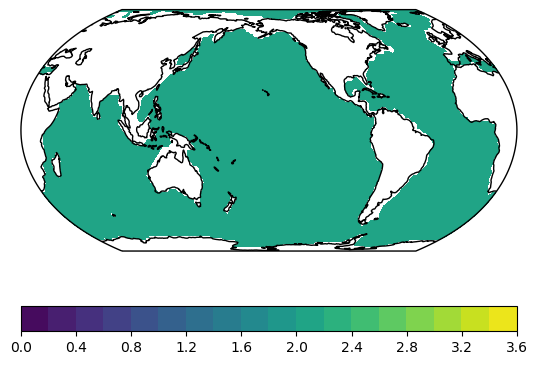

In [20]:
p = contourf(lon_cyc, lat, DIP_2D_cyc, levels=0:0.2:3.6, transform=ccrs.PlateCarree(), zorder=-1)
colorbar(p, orientation="horizontal");
gcf()

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*